In [3]:
import fpm_helper as fpm_helper
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import json
import os


# Results Slides Figures

## Slide 1 - Fourier Coverage Single Color

Using stock object data


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:205: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  im = torch.from_numpy(image.imread(path))[:, :, 0]  # Use first channel
/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:765: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_width_ind = int(torch.floor(torch.tensor(f_width/df)))  # Convert to PyTorch operation


Creating spiral LED pattern...
Creating illumination configurations...


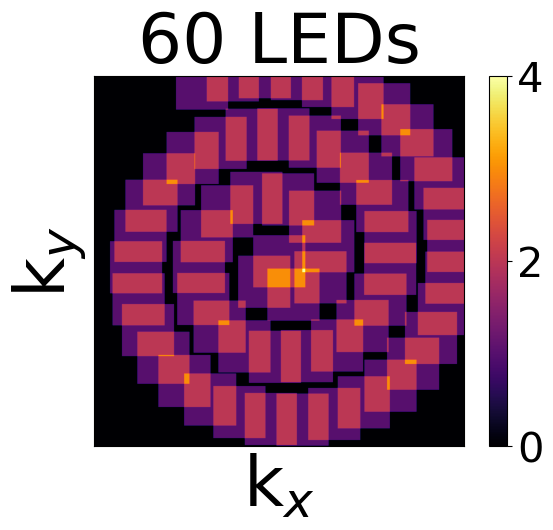

Nonzero coverage: 1019292.00 pixels
Overlap coverage: 524046.00 pixels
SSIM value at wavelength 500.0nm: 0.7965
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


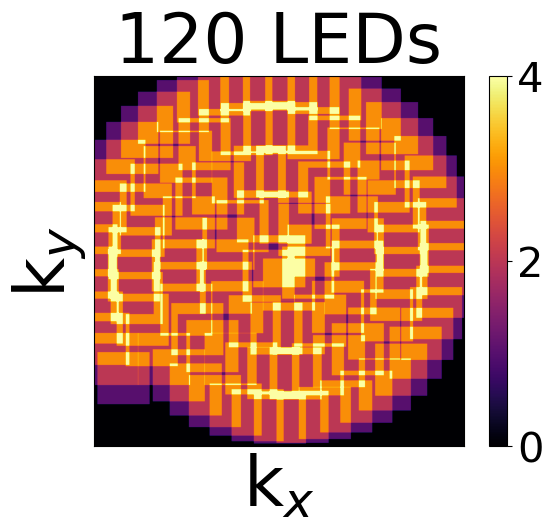

Nonzero coverage: 1221301.00 pixels
Overlap coverage: 1143106.00 pixels
SSIM value at wavelength 500.0nm: 0.8584
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


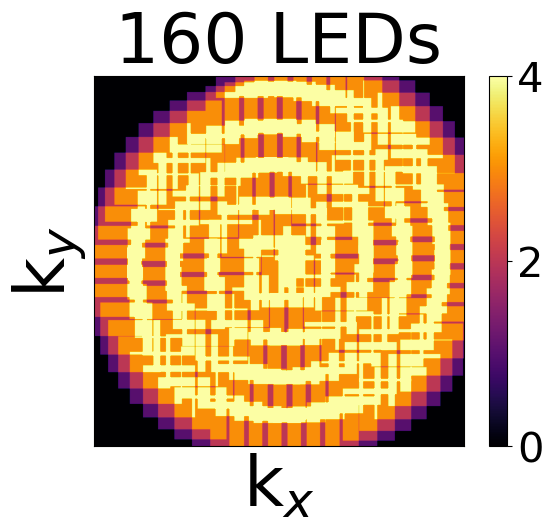

Nonzero coverage: 1238440.00 pixels
Overlap coverage: 1182346.00 pixels
SSIM value at wavelength 500.0nm: 0.9284
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


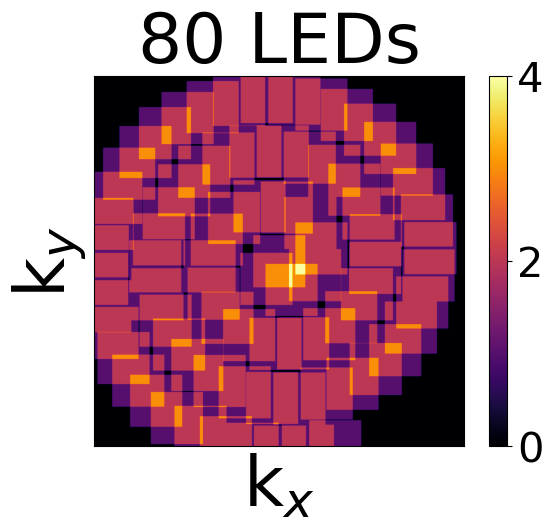

Nonzero coverage: 1152002.00 pixels
Overlap coverage: 855675.00 pixels
SSIM value at wavelength 500.0nm: 0.8323
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


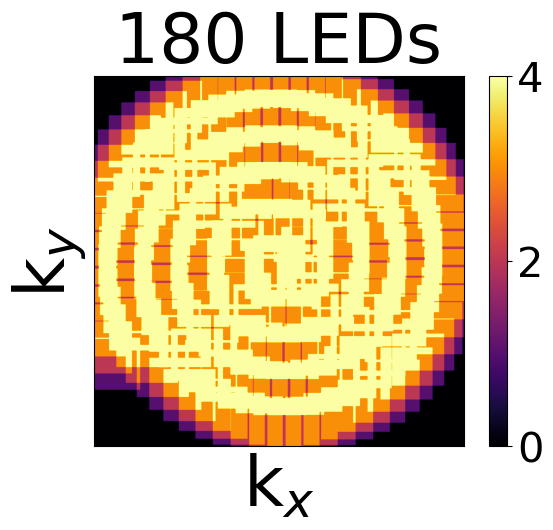

Nonzero coverage: 1251399.00 pixels
Overlap coverage: 1199056.00 pixels
SSIM value at wavelength 500.0nm: 0.8085
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


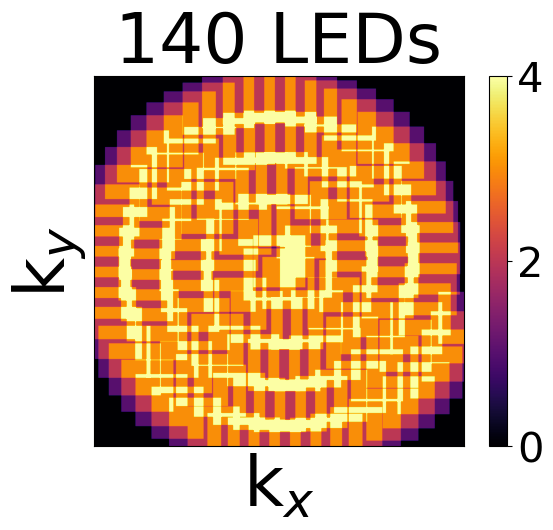

Nonzero coverage: 1240716.00 pixels
Overlap coverage: 1179469.00 pixels
SSIM value at wavelength 500.0nm: 0.9336
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


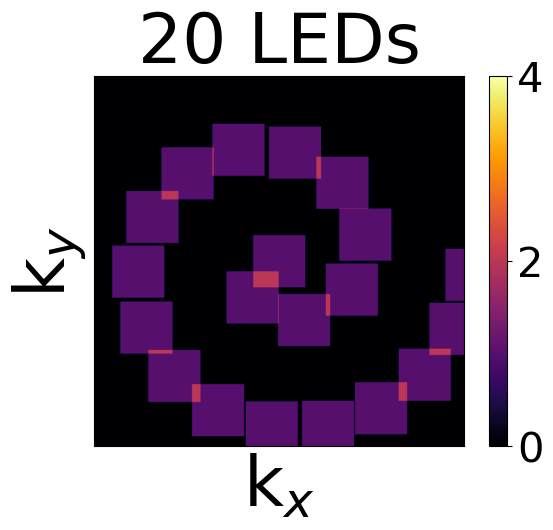

Nonzero coverage: 502760.00 pixels
Overlap coverage: 13666.00 pixels
SSIM value at wavelength 500.0nm: 0.6445
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


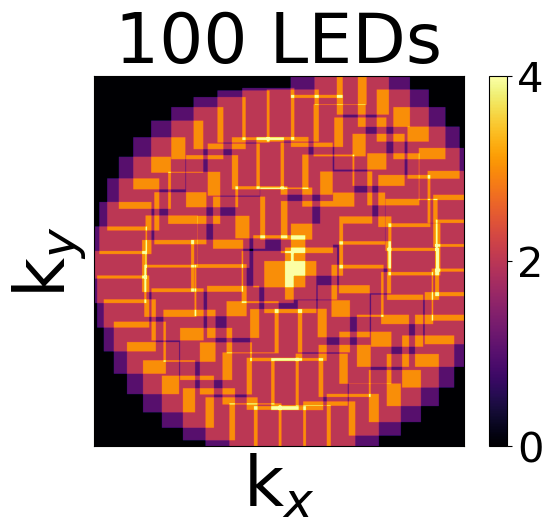

Nonzero coverage: 1201937.00 pixels
Overlap coverage: 1081010.00 pixels
SSIM value at wavelength 500.0nm: 0.7872
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


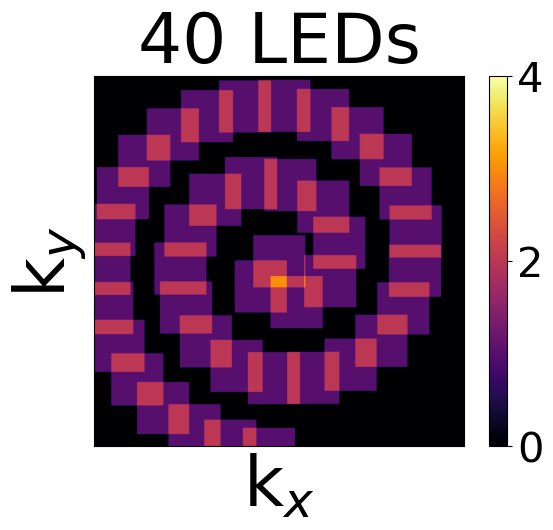

Nonzero coverage: 807849.00 pixels
Overlap coverage: 233777.00 pixels
SSIM value at wavelength 500.0nm: 0.7581
Using stock object data
Creating spiral LED pattern...
Creating illumination configurations...


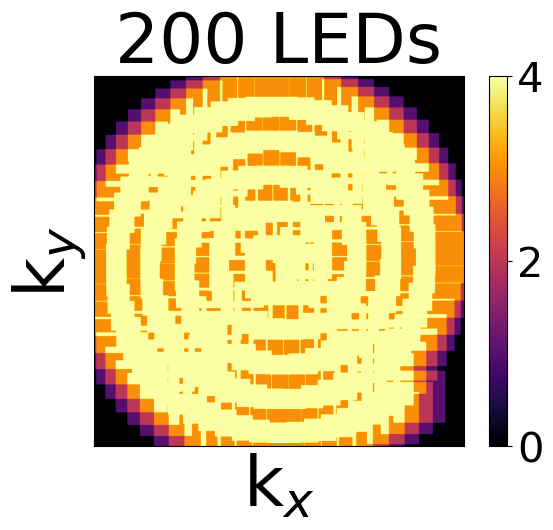

Nonzero coverage: 1268369.00 pixels
Overlap coverage: 1218860.00 pixels
SSIM value at wavelength 500.0nm: 0.8211


In [4]:
ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=11)

# Set the results directory for the LED sweep
sweep_results_dir = '/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250126_num_leds_sweep_na005_newspiral'

# Initialize lists to store results
num_leds_list = []
ssim_values = []
ssim_values_wavelength_list = []
# Get all run directories
run_dirs = [d for d in os.listdir(sweep_results_dir) if os.path.isdir(os.path.join(sweep_results_dir, d))]
nonzero_coverage_list = []
overlap_coverage_list = []

# Process each run
for run_id in run_dirs:
    # Load config file
    with open(f'{sweep_results_dir}/{run_id}/config_{run_id}.json', 'r') as f:
        config = json.load(f)
    
    # Get number of LEDs from config
    num_leds = config['led_array']['num_leds']
    num_leds_list.append(num_leds)
    
    # Create FPM setup
    micro_cfg = config['microscope']
    fpm_setup = fpm_helper.FPM_setup(
        pix_size_camera=micro_cfg['pixel_size_camera'],
        mag=micro_cfg['magnification'],
        wv=np.arange(micro_cfg['wavelength']['start'], 
                    micro_cfg['wavelength']['end'], 
                    micro_cfg['wavelength']['step']),
        na_obj=micro_cfg['na_objective'],
        led_spacing=config['led_array']['spacing'],
        dist=config['led_array']['distance'],
        spectral_obj=micro_cfg['spectral_obj']
    )
        # Create LED array
    print(f"Creating {config['led_array']['pattern']} LED pattern...")
    if config['led_array']['pattern'] == 'random':
        list_leds = fpm_helper.createlist_led(
            num_leds=config['led_array']['num_leds'],
            minval=config['led_array']['min_val'],
            maxval=config['led_array']['max_val']
        )
    elif config['led_array']['pattern'] == 'spiral':
        list_leds = fpm_helper.create_spiral_leds_CLV(
            num_leds=config['led_array']['num_leds'],
            minval=config['led_array']['min_val'],
            maxval=config['led_array']['max_val'],
            alpha=config['led_array']['alpha']
        )
    else:
        raise ValueError(f"Unsupported LED pattern: {config['led_array']['pattern']}")
    
    fpm_setup.list_leds = list_leds
    # Create illumination list and measurement stack
    print("Creating illumination configurations...")
    fpm_setup.createUniformWavelengthPerAngleIllumList()

    # get the tile
    tile = fpm_setup.createTile()
    fpm_setup.createAperture(tile)
    fpm_setup.updatePupilWithAperture()
    coverage = torch.squeeze(fpm_setup.visualize_objectfft_coverage())
    plt.imshow(coverage, cmap = 'inferno')
    cbar = plt.colorbar()
    plt.clim(0, 4)
    cbar.set_ticks([0, 2, 4])
    cbar.ax.tick_params(labelsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('k$_x$', fontsize = 50)
    plt.ylabel('k$_y$', fontsize = 50)
    plt.title(f'{num_leds} LEDs', fontsize = 50)
    plt.show()

    # compute the coverage
    nonzero_coverage = torch.count_nonzero(coverage)
    overlap_coverage = torch.count_nonzero(coverage > 1)
    print(f"Nonzero coverage: {nonzero_coverage:.2f} pixels")
    print(f"Overlap coverage: {overlap_coverage:.2f} pixels")
    nonzero_coverage_list.append(nonzero_coverage)
    overlap_coverage_list.append(overlap_coverage)

    # Load reconstructed object
    spectral_obj = torch.from_numpy(np.load(f'{sweep_results_dir}/{run_id}/reconstructed_object.npy'))
    gt_object = fpm_setup.objstack
    wavelengths = fpm_setup.wv * 1e3  # convert to nm
    
    # Calculate average SSIM across all wavelengths
    ssim_vals_wavelength = []
    for k in range(len(wavelengths)):
        curr_recon = spectral_obj[k,:,:]
        curr_recon = (curr_recon - curr_recon.min()) / (curr_recon.max() - curr_recon.min())
        curr_gt = gt_object[k,:,:]
        curr_gt = (curr_gt - curr_gt.min()) / (curr_gt.max() - curr_gt.min())
        
        curr_recon = curr_recon.unsqueeze(0).unsqueeze(0)
        curr_gt = curr_gt.unsqueeze(0).unsqueeze(0)
        
        ssim_val = ssim(curr_recon, curr_gt)
        ssim_vals_wavelength.append(ssim_val.item())
        print(f"SSIM value at wavelength {wavelengths[k]:.1f}nm: {ssim_val.item():.4f}")
    
    ssim_values.append(np.mean(ssim_vals_wavelength))
    ssim_values_wavelength_list.append([num_leds, ssim_vals_wavelength])


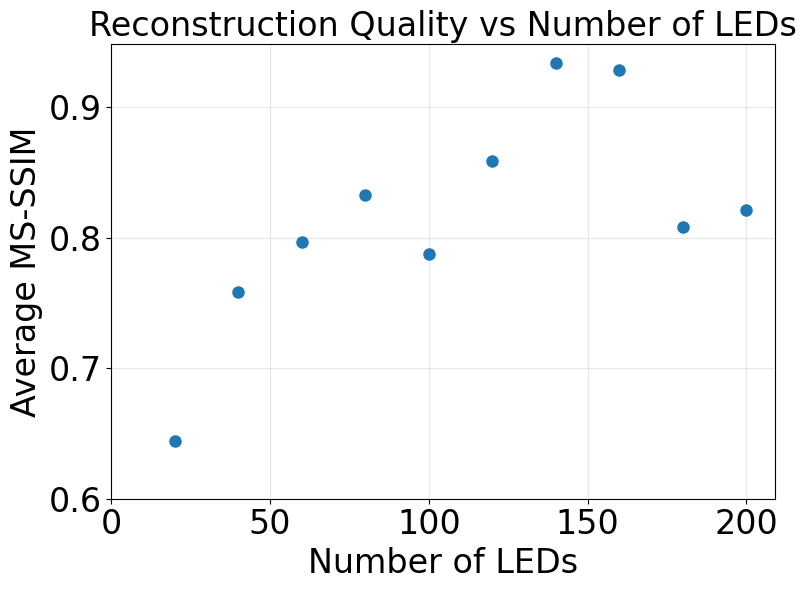

Number of LEDs:  20, Average MS-SSIM: 0.6445
Number of LEDs:  40, Average MS-SSIM: 0.7581
Number of LEDs:  60, Average MS-SSIM: 0.7965
Number of LEDs:  80, Average MS-SSIM: 0.8323
Number of LEDs: 100, Average MS-SSIM: 0.7872
Number of LEDs: 120, Average MS-SSIM: 0.8584
Number of LEDs: 140, Average MS-SSIM: 0.9336
Number of LEDs: 160, Average MS-SSIM: 0.9284
Number of LEDs: 180, Average MS-SSIM: 0.8085
Number of LEDs: 200, Average MS-SSIM: 0.8211


In [5]:

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(num_leds_list, ssim_values, 'o', linewidth=2, markersize=8)
plt.xlabel('Number of LEDs', fontsize=24)
plt.ylabel('Average MS-SSIM', fontsize=24)
plt.title('Reconstruction Quality vs Number of LEDs', fontsize=24)
plt.xticks(plt.xticks()[0][::2], fontsize=24)
plt.yticks(plt.yticks()[0][::2], fontsize=24)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print numerical results
for n, s in sorted(zip(num_leds_list, ssim_values)):
    print(f"Number of LEDs: {n:3d}, Average MS-SSIM: {s:.4f}")  

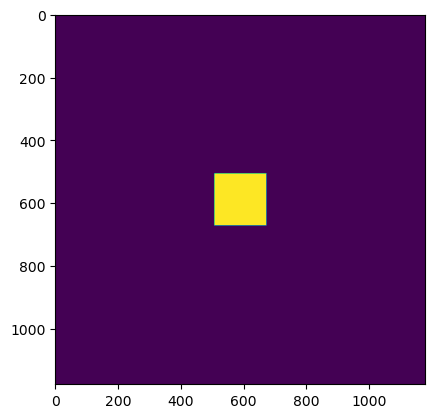

Pupil area: 27556.00 pixels
Total area: 1387684.00 pixels
Ratio of pupil area to total area: 0.02


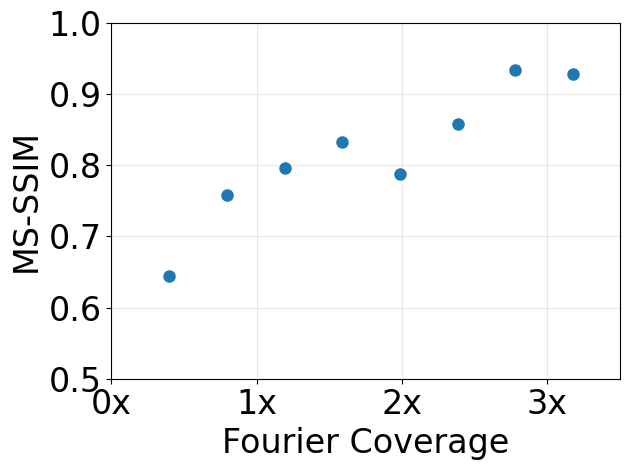

In [6]:
pupil = fpm_setup.pupilstack[0,:,:]
plt.imshow(torch.squeeze(torch.abs(pupil)))
plt.show()

pupil_area = torch.sum(torch.abs(pupil))
print(f"Pupil area: {pupil_area:.2f} pixels")
total_area = torch.numel(pupil)
print(f"Total area: {total_area:.2f} pixels")
ratio = pupil_area/total_area
print(f"Ratio of pupil area to total area: {ratio:.2f}")

# plot the ssim values at each wavelength for each num_leds but as a percentage of the total area
ratio_list = torch.tensor(num_leds_list)*ratio * 100
plt.plot(ratio_list, ssim_values,'o', markersize=8)
# Get current x-ticks
current_ticks = plt.xticks()[0]
# Create new tick labels in format 1x, 2x etc
new_labels = [f"{x/100:.1f}x" for x in current_ticks]
plt.xticks(current_ticks[current_ticks % 100 == 0], [f"{x/100:.0f}x" for x in current_ticks[current_ticks % 100 == 0]], fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Fourier Coverage', fontsize=24)
plt.ylabel('MS-SSIM', fontsize=24)
plt.xlim([0,350])
plt.ylim([0.5,1])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




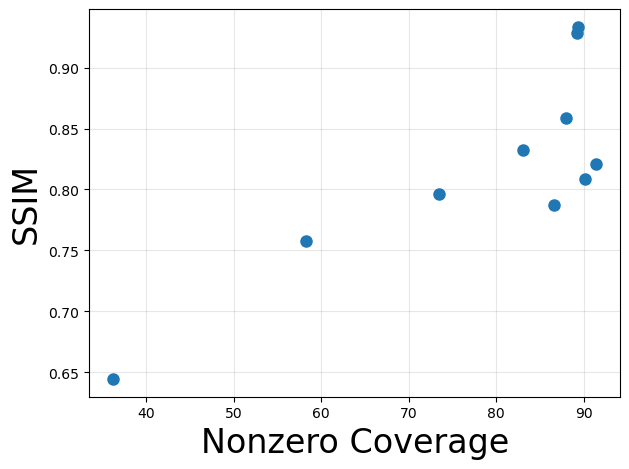

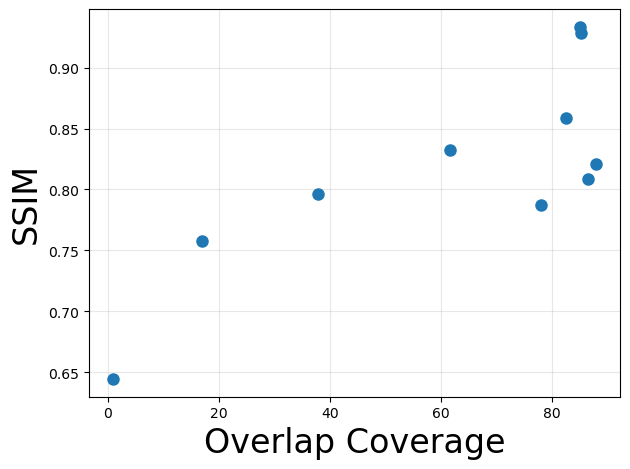

In [7]:
nonzero_coverage_list = torch.tensor(nonzero_coverage_list)
overlap_coverage_list = torch.tensor(overlap_coverage_list)
nonzero_ratio = nonzero_coverage_list/total_area*100
overlap_ratio = overlap_coverage_list/total_area*100

plt.plot(nonzero_ratio, ssim_values,'o', markersize=8)
plt.xlabel('Nonzero Coverage', fontsize=24)
plt.ylabel('SSIM', fontsize=24)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(overlap_ratio, ssim_values,'o', markersize=8)
plt.xlabel('Overlap Coverage', fontsize=24)
plt.ylabel('SSIM', fontsize=24)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Slide 2 - Spectral results

In [66]:
# CHOOSE RESULTS DIR AND RUN ID
results_dir = '/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250126_na01_spectral_varying'
run_id = 'ba4hlr4i' # 500 meas
# run_id = 'dalk7kc0' # 300 meas

# Load config file
import json
with open(f'{results_dir}/{run_id}/config_{run_id}.json', 'r') as f:
    config = json.load(f)


# Extract microscope parameters
micro_cfg = config['microscope']
mag = micro_cfg['magnification']
pix_size_camera = micro_cfg['pixel_size_camera']
na_obj = micro_cfg['na_objective']
spectral_obj = micro_cfg['spectral_obj']
# Create wavelength range
wv_cfg = micro_cfg['wavelength']
wv_range = np.arange(wv_cfg['start'], wv_cfg['end'], wv_cfg['step'])
# print(f"Using wavelength range: {wv_range} microns")

# Create FPM setup
fpm_setup = fpm_helper.FPM_setup(
    pix_size_camera=pix_size_camera,
    mag=mag,
    wv=wv_range,
    na_obj=na_obj,
    led_spacing=config['led_array']['spacing'],
    dist=config['led_array']['distance'],
    spectral_obj=spectral_obj
)


Using stock object data


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:344: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelengths = torch.tensor(wavelengths, dtype=torch.float32)


In [17]:
# compute the coverage
# Create LED array
list_leds = fpm_helper.create_spiral_leds_CLV(
    num_leds=config['led_array']['num_leds'],
    minval=config['led_array']['min_val'],
    maxval=config['led_array']['max_val'],
    alpha=config['led_array']['alpha']
)

fpm_setup.list_leds = list_leds
print("Creating illumination configurations...")
fpm_setup.createUniformWavelengthPerAngleIllumList()

tile = fpm_setup.createTile()
fpm_setup.createAperture(tile)
fpm_setup.updatePupilWithAperture()
pupilstack = fpm_setup.pupilstack
# compute the area of the pupil for each wavelength
pupil_area = torch.sum(torch.abs(pupilstack), dim=(1,2))  # Sum over spatial dimensions for each wavelength
total_area = pupilstack.shape[1] * pupilstack.shape[2]  # Total pixels in each channel

# Calculate ratio for each wavelength
ratios = pupil_area/total_area
num_meas_for1p5x = 1/ratios*1.5

# Print ratios for each wavelength
for i, wv in enumerate(fpm_setup.wv):
    print(f"Wavelength {wv*1e3:.1f}nm - Pupil area: {pupil_area[i]:.2f} pixels, " 
          f"Total area: {total_area} pixels, Ratio: {ratios[i]:.4f}")
    print(f"Number of measurements for 1.5x coverage: {num_meas_for1p5x[i]:.2f}")

# coverage = torch.squeeze(fpm_setup.visualize_objectfft_coverage())
# plt.imshow(coverage[0,:,:], cmap = 'inferno')
# plt.show()


Creating illumination configurations...
Wavelength 500.0nm - Pupil area: 24642.00 pixels, Total area: 1387684 pixels, Ratio: 0.0178
Number of measurements for 1.5x coverage: 84.47
Wavelength 550.0nm - Pupil area: 10000.00 pixels, Total area: 1387684 pixels, Ratio: 0.0072
Number of measurements for 1.5x coverage: 208.15
Wavelength 600.0nm - Pupil area: 8464.00 pixels, Total area: 1387684 pixels, Ratio: 0.0061
Number of measurements for 1.5x coverage: 245.93
Wavelength 650.0nm - Pupil area: 7225.00 pixels, Total area: 1387684 pixels, Ratio: 0.0052
Number of measurements for 1.5x coverage: 288.10
Wavelength 700.0nm - Pupil area: 6241.00 pixels, Total area: 1387684 pixels, Ratio: 0.0045
Number of measurements for 1.5x coverage: 333.52
Wavelength 750.0nm - Pupil area: 5476.00 pixels, Total area: 1387684 pixels, Ratio: 0.0039
Number of measurements for 1.5x coverage: 380.12
Wavelength 800.0nm - Pupil area: 4761.00 pixels, Total area: 1387684 pixels, Ratio: 0.0034
Number of measurements for 1

/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:765: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_width_ind = int(torch.floor(torch.tensor(f_width/df)))  # Convert to PyTorch operation


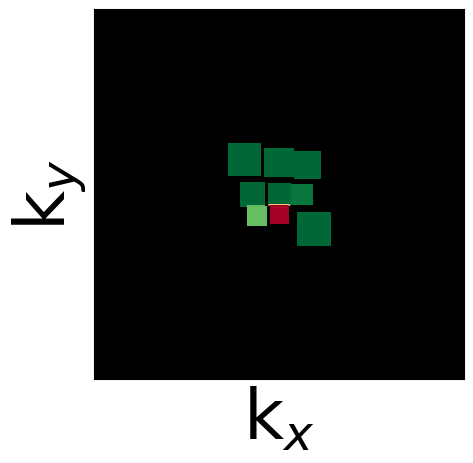

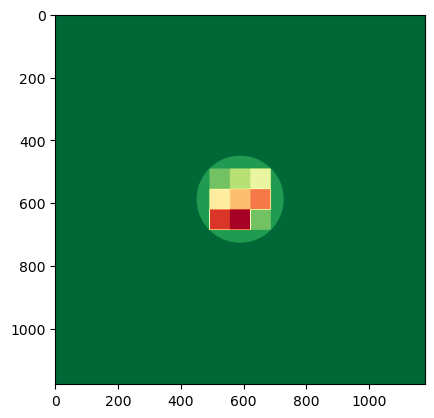

In [49]:
fpm_setup.resetPupil()
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap from green to orange to red
colors = ['green', 'orange', 'red'] 
n_bins = 256  # Number of color gradations
custom_cmap = LinearSegmentedColormap.from_list('custom', ['green', 'orange', 'orange', 'red'], N=n_bins)

pupilstack = fpm_setup.pupilstack
aperturestack = fpm_setup.aperture_stack
aperture = torch.from_numpy(fpm_setup.aperture)

# plt.figure()
# plt.imshow(torch.sum(pupilstack, axis=0).real)
# plt.show()

for i in range(aperturestack.shape[0]):
    aperturestack[i] = aperturestack[i] * (i + 1)

plt.figure()
# Create a masked array where 0 values will be shown as black
data = torch.sum(aperturestack, axis=0)
masked_data = np.ma.masked_where(data == 0, data)

# Plot with black background
plt.imshow(masked_data, cmap='RdYlGn_r')
plt.xticks([])
plt.yticks([])
plt.xlabel('k$_x$', fontsize=50)
plt.ylabel('k$_y$', fontsize=50)
plt.gca().set_facecolor('black') 
plt.show()

plt.figure()
plt.imshow(aperture+pupilstack[-1,:,:].real, cmap = 'RdYlGn_r')
plt.show()

p = fpm_setup.updatePupilWithAperture()


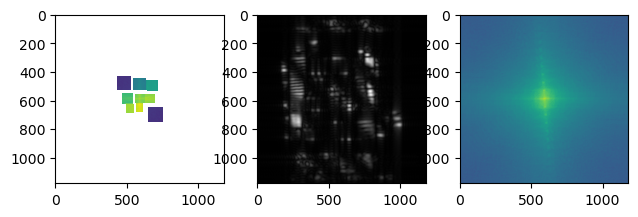

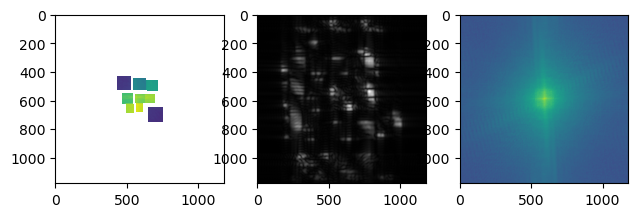

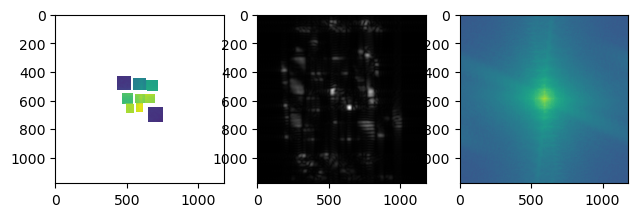

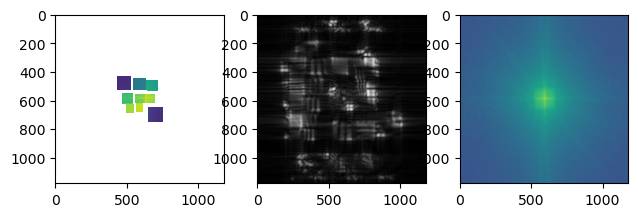

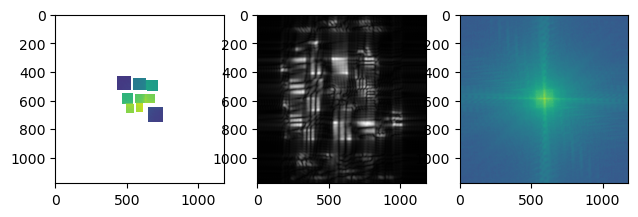

tensor([[[11710109.0000, 17351264.0000, 23667992.0000,  ...,
          20883130.0000, 15170615.0000, 11495618.0000],
         [ 7967737.0000, 12709512.0000, 19549904.0000,  ...,
          23742988.0000, 16584951.0000,  9810748.0000],
         [ 7088711.0000,  7783797.0000, 15277103.0000,  ...,
          26725858.0000, 19164284.0000, 11906295.0000],
         ...,
         [27274284.0000, 30162854.0000, 33617176.0000,  ...,
          19139056.0000, 21597428.0000, 24340120.0000],
         [22677384.0000, 26008018.0000, 30703288.0000,  ...,
          18008674.0000, 18234410.0000, 19951256.0000],
         [17370786.0000, 21677890.0000, 27396620.0000,  ...,
          18708520.0000, 15756736.0000, 15404236.0000]],

        [[21288864.0000, 25089124.0000, 28339700.0000,  ...,
          10273432.0000, 12969290.0000, 17110970.0000],
         [18642978.0000, 22669468.0000, 26238804.0000,  ...,
          10254791.0000, 10469412.0000, 14390500.0000],
         [15764911.0000, 19827292.0000, 23624714

In [50]:
# plot some measurements
fpm_setup.createMeasStackFromListIllums()


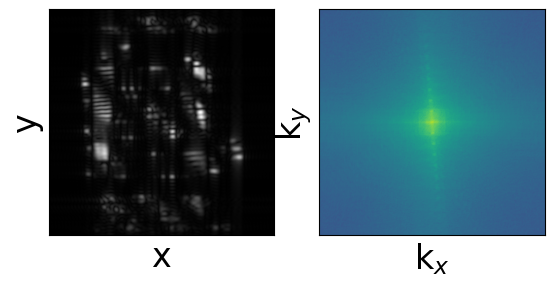

In [60]:
# plot more cleanly

k = 0 
plt.subplot(1,2,1)
plt.imshow(fpm_setup.measstack[k,:,:].real, cmap = 'gray')
plt.xticks([])
plt.yticks([])  
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.subplot(1,2,2)
plt.imshow(torch.log(torch.fft.fftshift(torch.fft.fft2(fpm_setup.measstack[k,:,:].real)).abs()))
plt.xticks([])
plt.yticks([])
plt.xlabel('k$_x$', fontsize=24)
plt.ylabel('k$_y$', fontsize=24)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7026304..2.723593].


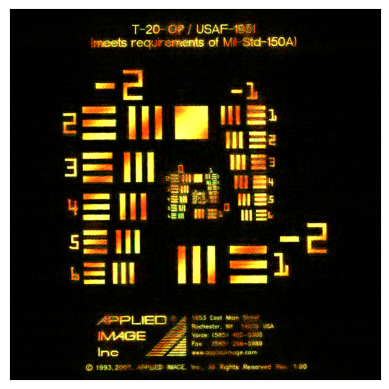

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43927905..2.486005].


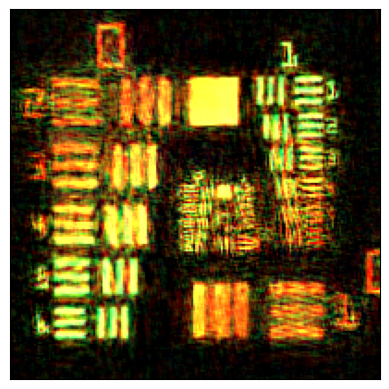

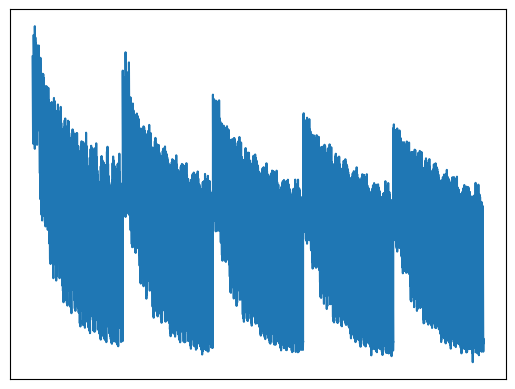

MSE at wavelength 500.0nm: 0.030116
SSIM value at wavelength 500.0nm: 0.7637
MSE at wavelength 550.0nm: 0.100603
SSIM value at wavelength 550.0nm: 0.7036
MSE at wavelength 600.0nm: 0.106599
SSIM value at wavelength 600.0nm: 0.7078
MSE at wavelength 650.0nm: 0.094236
SSIM value at wavelength 650.0nm: 0.7143
MSE at wavelength 700.0nm: 0.081475
SSIM value at wavelength 700.0nm: 0.7016
MSE at wavelength 750.0nm: 0.082140
SSIM value at wavelength 750.0nm: 0.7136
MSE at wavelength 800.0nm: 0.105496
SSIM value at wavelength 800.0nm: 0.6992
MSE at wavelength 850.0nm: 0.103182
SSIM value at wavelength 850.0nm: 0.6484
Avg MSE: 0.087981
Avg MS-SSIM: 0.7065


In [83]:
results_dir = '/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250126_na01_spectral_varying'
run_id = 'ba4hlr4i' # 500 meas
run_id = 'dalk7kc0' # 300 meas, 3 epochs
results_dir = '/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250127_na01_spectral_varying'
run_id = '33deyv5k' # 300 meas, 5 epochs
run_id = 'hqspwnkf' # 160 meas, 5 epochs

spectral_obj = np.load(f'{results_dir}/{run_id}/reconstructed_object.npy')
# Convert numpy array to torch tensor
spectral_obj = torch.from_numpy(spectral_obj)

wavelengths = fpm_setup.wv * 1e3 # convert to nm
rgb_recon = fpm_helper.spectral_obj_to_color(spectral_obj, wavelengths)

# plot the spectral object
plt.imshow(rgb_recon)
plt.xticks([])
plt.yticks([])
plt.show()

zoom_size = 200  # Adjust this value to change zoom level
center_y, center_x = rgb_recon.shape[0] // 2, rgb_recon.shape[1] // 2
zoom_recon = rgb_recon.detach().cpu().numpy()[
    center_y - zoom_size // 2:center_y + zoom_size // 2,
    center_x - zoom_size // 2:center_x + zoom_size // 2
]

plt.figure()
plt.imshow(zoom_recon)
plt.xticks([])
plt.yticks([])
plt.show()

# plot loss
loss = np.load(f'{results_dir}/{run_id}/loss_history.npy')
plt.figure()
plt.plot(np.log(loss))
# plt.xlabel('Iteration', fontsize=24)
plt.xticks([])
plt.yticks([])
# plt.ylabel('Loss', fontsize=24)
plt.show()

# print final MSE and MS-SSIM
ssim_vals = []
mse_list = []
for k in range(spectral_obj.shape[0]):
    curr_recon = spectral_obj[k,:,:]
    curr_recon = (curr_recon - curr_recon.min()) / (curr_recon.max() - curr_recon.min())
    curr_gt = gt_object[k,:,:]
    curr_gt = (curr_gt - curr_gt.min()) / (curr_gt.max() - curr_gt.min())
    mse = torch.nn.functional.mse_loss(curr_recon, curr_gt).item()
    mse_list.append(mse)
    print(f'MSE at wavelength {wv_range[k]*1e3:.1f}nm: {mse:.6f}')

    curr_recon = curr_recon.unsqueeze(0).unsqueeze(0)
    curr_gt = curr_gt.unsqueeze(0).unsqueeze(0)
    ssim_val = ssim(curr_recon, curr_gt)
    ssim_vals.append(ssim_val.item())
    print(f"SSIM value at wavelength {wv_range[k]*1e3:.1f}nm: {ssim_val.item():.4f}")

print(f"Avg MSE: {np.mean(mse_list):.6f}")
print(f"Avg MS-SSIM: {np.mean(ssim_vals):.4f}")






In [107]:
import wandb
from PIL import Image
import matplotlib.pyplot as plt
import tempfile
import os
import time

# Initialize wandb API
api = wandb.Api()

run_id = 'ws03ej6w'
# Access your specific run
run = api.run(f"wallerlab/Spectral_FPM/{run_id}")

# Create temporary directory
temp_dir = tempfile.mkdtemp()

try:
    # Get files from the run
    files = run.files()
    
    # Create list to store images and their iteration numbers
    xy_estimates_with_iter = []

    # Filter for XY Object Estimate images
    for file in files:
        if "XY Object Estimate" in file.name and file.name.endswith('.png'):
            try:
                # Extract the 4-digit iteration number that comes after "Estimate_"
                iter_str = file.name.split('Estimate_')[1].split('_')[0]
                iter_num = int(iter_str)
                
                file_path = os.path.join(temp_dir, file.name)
                print(f"Downloading: {file.name} (iteration {iter_num})")
                
                file.download(root=temp_dir, replace=True)
                time.sleep(0.1)
                
                if os.path.exists(file_path):
                    image = Image.open(file_path)
                    xy_estimates_with_iter.append((iter_num, image))
                    print(f"Successfully loaded: {file.name} (iteration {iter_num})")
                
            except Exception as e:
                print(f"Error processing {file.name}: {e}")
                continue

    # Sort by iteration number
    xy_estimates_with_iter.sort(key=lambda x: x[0])
    # Extract just the images in order
    xy_estimates = [img for _, img in xy_estimates_with_iter]


finally:
    # Clean up: remove temporary directory and its contents
    import shutil
    shutil.rmtree(temp_dir, ignore_errors=True)

Downloading: media/images/XY Object Estimate_10016_2fd367f6f78b8eed7187.png (iteration 10016)
Successfully loaded: media/images/XY Object Estimate_10016_2fd367f6f78b8eed7187.png (iteration 10016)
Downloading: media/images/XY Object Estimate_10069_fc149445dcc69c1483ad.png (iteration 10069)
Successfully loaded: media/images/XY Object Estimate_10069_fc149445dcc69c1483ad.png (iteration 10069)
Downloading: media/images/XY Object Estimate_1006_362eaa64d26cf283bda5.png (iteration 1006)
Successfully loaded: media/images/XY Object Estimate_1006_362eaa64d26cf283bda5.png (iteration 1006)
Downloading: media/images/XY Object Estimate_10122_e6bd43f455e39e7a9ac9.png (iteration 10122)
Successfully loaded: media/images/XY Object Estimate_10122_e6bd43f455e39e7a9ac9.png (iteration 10122)
Downloading: media/images/XY Object Estimate_10175_938b76bd8e8c178f0537.png (iteration 10175)
Successfully loaded: media/images/XY Object Estimate_10175_938b76bd8e8c178f0537.png (iteration 10175)
Downloading: media/image


Found 240 images


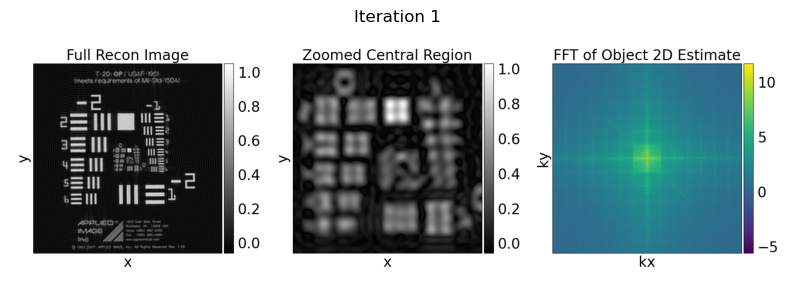

In [108]:
# make a gif
if xy_estimates:
    print(f"\nFound {len(xy_estimates)} images")
    
    # Display images
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, img in enumerate(xy_estimates):
        ax.clear()
        ax.imshow(img)
        ax.set_title(f'Iteration {i+1}')
        ax.axis('off')
        plt.pause(0.1)
    
    # Save as GIF using PIL
    xy_estimates[0].save('xy_reconstruction.gif', 
                        save_all=True, 
                        append_images=xy_estimates[1:], 
                        duration=500,  # Duration for each frame in milliseconds
                        loop=0)  # 0 means loop forever
else:
    print("No images found in the history")